In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import camb

import bornraytrace.lensing as lensing

import glass.shells

from forward_model import preprocessing_gower_street, forward, weight_map_w_redshift, kappa2shear
from ray_trace import ray_trace, intrinsic_alignments
from utils import downgrade_mask

In [2]:
path_info = '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv'
path_sims = '/n17data/sguerrini/GowerStreetSims/'
sim_number = 2
nside = 512

In [3]:
overdensity_array, z_bin_edges, cosmo_params = preprocessing_gower_street(path_sims, path_info, sim_number, nside=nside, verbose=True)

[!] Preprocessing the Gower Street simulation 2...
[!] Reading the cosmological parameters...
[!] Done in 3.19 min.
[!] Extracting overdensity maps and redshift edges for the Gower Street simulation 2...


100it [03:32,  2.12s/it]


[!] Done in 3.55 min.
[!] Number of redshift shells: 76
[!] Larger redshift: 2.09686


In [4]:
cosmo_params

{'h': array([0.71654738]),
 'Omega_m': array([0.24962876]),
 'Omega_b': array([0.04350883]),
 'sigma_8': array([0.95049616]),
 'n_s': array([0.95131107]),
 'w': array([-0.7924174]),
 'm_nu': array([0.06]),
 'A_s': array([3.96819025e-09])}

In [5]:
mean_density = np.mean(overdensity_array[z_bin_edges[1:]<0.15], axis=0)

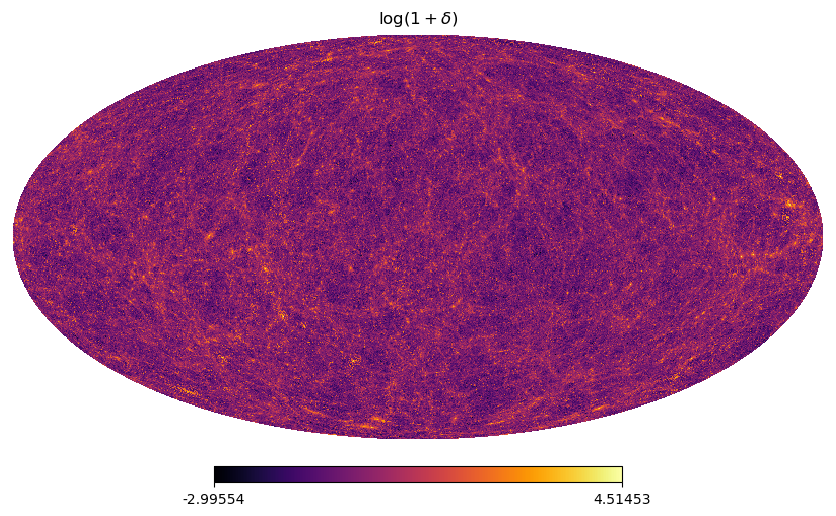

In [6]:
hp.mollview(np.log(mean_density+1), title=r'$\log(1+\delta)$', cmap='inferno')
plt.savefig('../Plots/mean_overdensity.png', dpi=300)
plt.show()

In [7]:
kappa_lensing = ray_trace(overdensity_array, z_bin_edges, cosmo_params, method='glass', verbose=True)
kappa_lensing_brt = ray_trace(overdensity_array, z_bin_edges, cosmo_params, method='bornraytrace', verbose=True)

[!] Performing the ray tracing using GLASS...


100%|██████████| 76/76 [00:02<00:00, 30.77it/s]


[!] Performing the ray tracing using BornRaytrace...


100%|██████████| 76/76 [00:38<00:00,  1.97it/s]


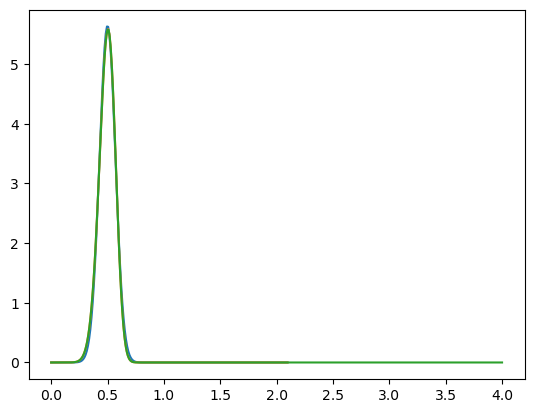

In [8]:
z = np.linspace(z_bin_edges[0], z_bin_edges[-1], 200)
dndz = np.exp(-(z-0.5)**2/0.1**2)
dndz /= np.trapz(dndz, z)

z_mode = 0.4390
alpha = 10
beta = 4.988
dndz_smail = (z/z_mode)**(alpha)*np.exp(-(z/z_mode)**beta)
dndz_smail /= np.trapz(dndz_smail, z)

path = '/home/guerrini/cosmosis-standard-library/ia_pred/nz_source/'

z_SIS = np.loadtxt(path+'z.txt')
dndz_SIS = np.loadtxt(path+'bin_1.txt')

plt.figure()

plt.plot(z, dndz)
plt.plot(z, dndz_smail)
plt.plot(z_SIS, dndz_SIS)
plt.show()

In [9]:
kappa_bar = np.zeros_like(kappa_lensing[0])
kappa_bar_brt = np.zeros_like(kappa_lensing[0])

weights = glass.shells.tophat_windows(z_bin_edges)

for i in range(len(z_bin_edges)-1):
    z_i, dndz_i = glass.shells.restrict(z, dndz, weights[i])

    ngal = np.trapz(dndz_i, z_i)
    kappa_bar += ngal * kappa_lensing[i]
    kappa_bar_brt += ngal * kappa_lensing_brt[i]

kappa_bar /= np.trapz(dndz, z)
kappa_bar_brt /= np.trapz(dndz, z)

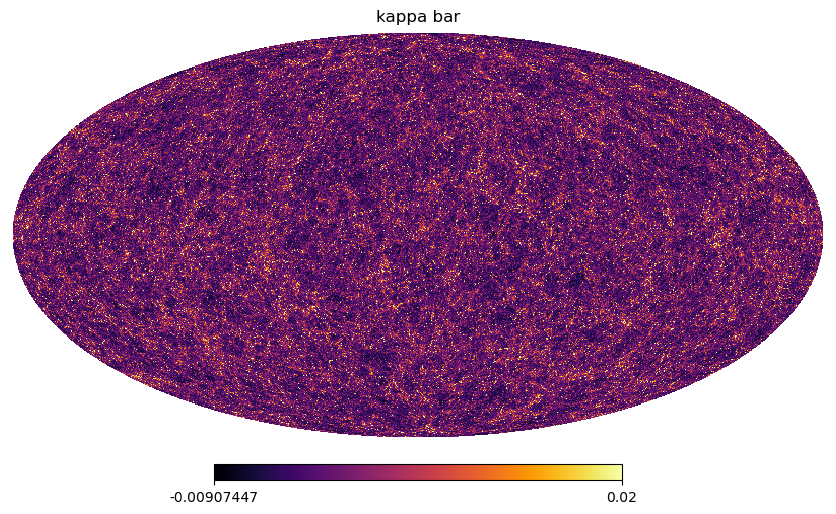

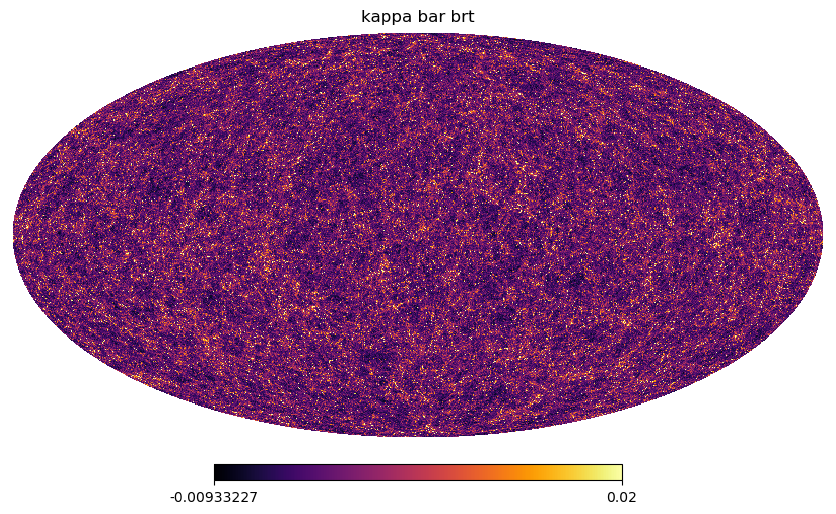

In [10]:
hp.mollview(kappa_bar, title='kappa bar', cmap='inferno', max=0.02)
plt.savefig('../Plots/kappa_bar.png', dpi=300)
plt.show()

hp.mollview(kappa_bar_brt, title='kappa bar brt', cmap='inferno', max=0.02)
plt.show()

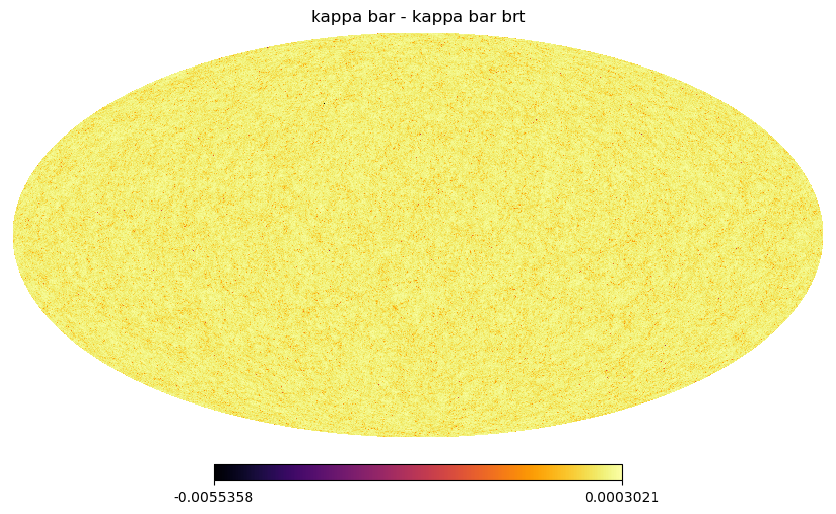

In [11]:
hp.mollview(kappa_bar - kappa_bar_brt, title='kappa bar - kappa bar brt', cmap='inferno')
plt.show()

In [12]:
#Comparison with the power spectrum

#Load parameters for the cosmology
h = cosmo_params["h"]
Om = cosmo_params["Omega_m"]
Ob = cosmo_params["Omega_b"]
Oc = Om - Ob
ns = cosmo_params["n_s"]
m_nu = cosmo_params["m_nu"]
w = cosmo_params["w"]
As = cosmo_params["A_s"]

nside=512
lmax = 2*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
Onu = pars.omeganu
Oc = Om - Ob - Onu
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#get the angular power spectra of the lensing map
sim_cls = hp.anafast(kappa_bar, pol=True, lmax=lmax, use_pixel_weights=True)
sim_cls_brt = hp.anafast(kappa_bar_brt, pol=True, lmax=lmax, use_pixel_weights=True)

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

In [13]:
pars.omegam

0.24962875840000004

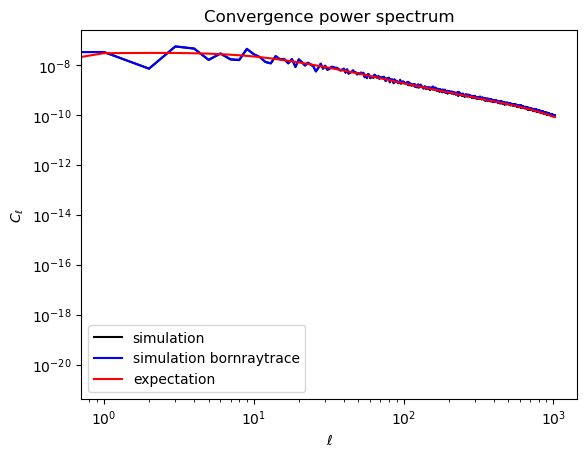

/tmp/ipykernel_830426/4042978123.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, sim_cls/(theory_cls['W1xW1']*pw**2))
/tmp/ipykernel_830426/4042978123.py:26: RuntimeWarning: divide by zero encountered in divide
  plt.plot(l, sim_cls_brt/(theory_cls['W1xW1']*pw**2))


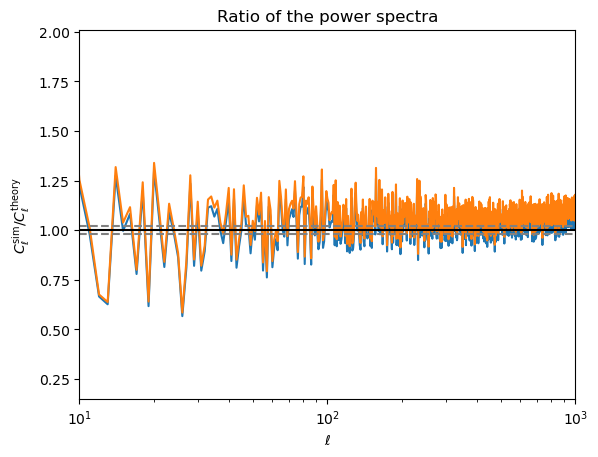

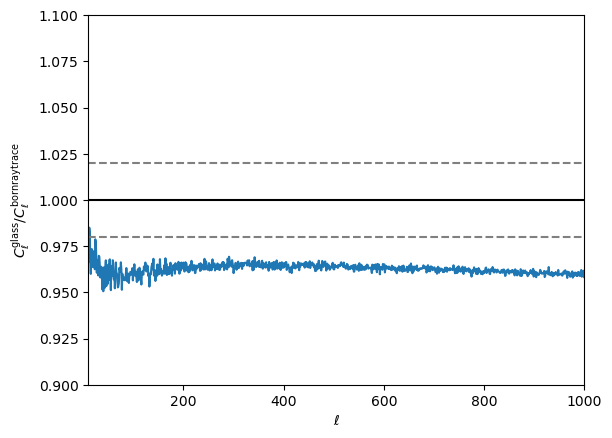

In [14]:
plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_cls, label="simulation", c='k')
plt.plot(l, sim_cls_brt, label="simulation bornraytrace", c='b')
plt.plot(l, theory_cls['W1xW1']*pw**2, label="expectation", c='r')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Convergence power spectrum")

plt.savefig('../Plots/power_spectrum.png', dpi=300)
plt.show()

plt.figure()

plt.plot(l, sim_cls/(theory_cls['W1xW1']*pw**2))
plt.plot(l, sim_cls_brt/(theory_cls['W1xW1']*pw**2))
plt.axhline(1, c='k')
plt.axhline(1.02, c='gray', ls='--')
plt.axhline(0.98, c='gray', ls='--')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{\rm sim}/C_\ell^{\rm theory}$")
plt.title("Ratio of the power spectra")

plt.xlim(10, 1e3)

plt.xscale('log')

plt.savefig('../Plots/power_spectrum_ratio.png', dpi=300)
plt.show()

plt.figure()

plt.plot(l, sim_cls/sim_cls_brt)
plt.axhline(1, c='k')
plt.axhline(1.02, c='gray', ls='--')
plt.axhline(0.98, c='gray', ls='--')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{\rm glass}/C_\ell^{\rm bornraytrace}$")

plt.xlim(10, 1e3)
plt.ylim(0.9, 1.1)

plt.savefig('../Plots/power_spectrum_ratio_ray_tracing.png', dpi=300)
plt.show()

In [15]:
def kappa_prefactor_glass(om0):
    return 1.5 * om0

def raytrace_integration_glass(kappa_prefactor, overdensity_array, z_bin_edges, cosmo, mask=None):
    """
    This function evaluates the Born weak lensing integral

    :param kappa_prefactor: defined as the output of the function kappa_prefactor
    :param overdensity_array: an 2D array of overdensity healpix maps in radial shells
    :param z_bin_edges: redshifts to edges of shells
    :param cosmo: cosmology object to compute distances
    :param mask: healpix map where 1 is observed and 0 is mask
    :return: convergence kappa map
    """

    assert overdensity_array.shape[1] + 1 == z_bin_edges.shape[0]

    dz_array = z_bin_edges[1:] - z_bin_edges[:-1]
    dz_array = np.concatenate((np.array([0.]), dz_array[:-1]))
    z_centres = 0.5*(z_bin_edges[1:] + z_bin_edges[:-1])
    centre_edges = np.concatenate((np.array([0.]), z_centres))
    z_max = centre_edges[-1]
    z_centre = centre_edges[:-1]

    xm_max = cosmo.xm(z_max)
    xm_centre = cosmo.xm(z_centre)
    xm_centre_max = cosmo.xm(z_centre, z_max)

    z_prefactors = dz_array * xm_centre*xm_centre_max /  (xm_max) * (1+z_centre)/cosmo.ef(z_centre)
    z_prefactors *= kappa_prefactor

    if mask is not None:
        mask = np.where(mask>0.5,1.,0.).T
        overdensity_array = (mask * overdensity_array.T).T

    overdensity_array = overdensity_array.T
    overdensity_array = np.concatenate((np.zeros((1,overdensity_array.shape[1])),overdensity_array),axis=0)
    overdensity_array = overdensity_array[:-1].T

    return np.sum(z_prefactors * overdensity_array,axis=1)

def raytrace_glass(cosmo, om0, overdensity_array, z_bin_edges, mask=None):
    """
    Evaluate weak lensing convergence map using Born approximation

    :param H0: Hubble parameter with astropy units
    :param om0: Omega matter
    :param overdensity_array: an 2D array of overdensity healpix maps in radial shells
    :param a_centre: scale factor at comoving centre of shells
    :param comoving_edges: comoving distance to edges of shells
    :param mask: healpix map where 1 is observed and 0 is mask
    :param length_unit: for H0 (default Mpc)
    :return: convergence kappa map
    """

    kappa_pref_evaluated = kappa_prefactor_glass(om0)

    kappa_raytraced = raytrace_integration_glass(kappa_pref_evaluated, overdensity_array, z_bin_edges, cosmo, mask)

    return kappa_raytraced

In [16]:
from cosmology import Cosmology
from tqdm import tqdm

cosmo = Cosmology.from_camb(pars)


kappa_lensing_brt_glass = np.copy(overdensity_array)*0.

pbar = tqdm(range(1, overdensity_array.shape[0]+1))

for i in pbar:
    kappa_lensing_brt_glass[i-1] = raytrace_glass(
        cosmo, Om,
        overdensity_array = overdensity_array[:i].T,
        z_bin_edges = z_bin_edges[:(i+1)]
    )

kappa_bar_brt_glass = np.zeros_like(kappa_lensing_brt_glass[0])
for i in range(len(z_bin_edges)-1):
    z_i, dndz_i = glass.shells.restrict(z, dndz, weights[i])

    ngal = np.trapz(dndz_i, z_i)
    kappa_bar_brt_glass += ngal * kappa_lensing_brt_glass[i]

kappa_bar_brt_glass /= np.trapz(dndz, z)

100%|██████████| 76/76 [01:05<00:00,  1.16it/s]


In [17]:
kappa_lensing_brt_glass[1]

array([-1.18859983e-05, -1.18859983e-05, -1.18859983e-05, ...,
       -1.18859983e-05, -1.18859983e-05, -1.18859983e-05])

In [18]:
kappa_lensing[1]

array([-1.18859983e-05, -1.18859983e-05, -1.18859983e-05, ...,
       -1.18859983e-05, -1.18859983e-05, -1.18859983e-05])

(0.9, 1.1)

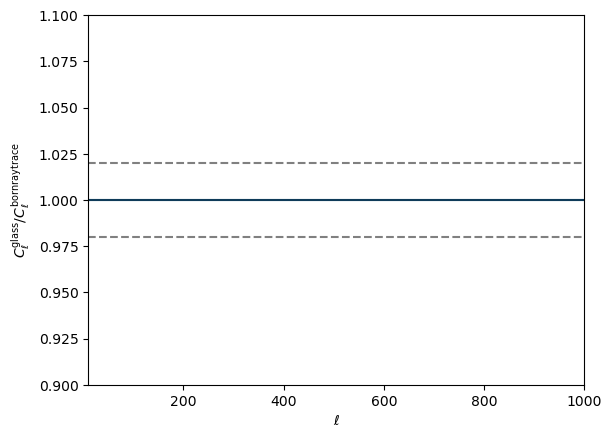

In [19]:
sim_cls_brt_glass = hp.anafast(kappa_bar_brt_glass, pol=True, lmax=lmax, use_pixel_weights=True)

plt.figure()

plt.plot(l, sim_cls/sim_cls_brt_glass)
plt.axhline(1, c='k', alpha=0.5)
plt.axhline(1.02, c='gray', ls='--')
plt.axhline(0.98, c='gray', ls='--')

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{\rm glass}/C_\ell^{\rm bornraytrace}$")

plt.xlim(10, 1e3)
plt.ylim(0.9, 1.1)

In [20]:
sim_cls/sim_cls_brt_glass

array([0.99999998, 1.        , 1.        , ..., 1.        , 1.        ,
       1.        ])

In [21]:
A_ia = 0.49
eta_ia = 0.

kappa_ia = intrinsic_alignments(overdensity_array, z_bin_edges, cosmo_params, A_ia=A_ia, eta_ia=eta_ia)

In [22]:
kappa_ia_bar = np.zeros_like(kappa_lensing[0])

weights = glass.shells.tophat_windows(z_bin_edges)

for i in range(len(z_bin_edges)-1):
    z_i, dndz_i = glass.shells.restrict(z, dndz, weights[i])

    ngal = np.trapz(dndz_i, z_i)
    kappa_ia_bar += ngal * kappa_ia[i]

kappa_ia_bar /= np.trapz(dndz, z)

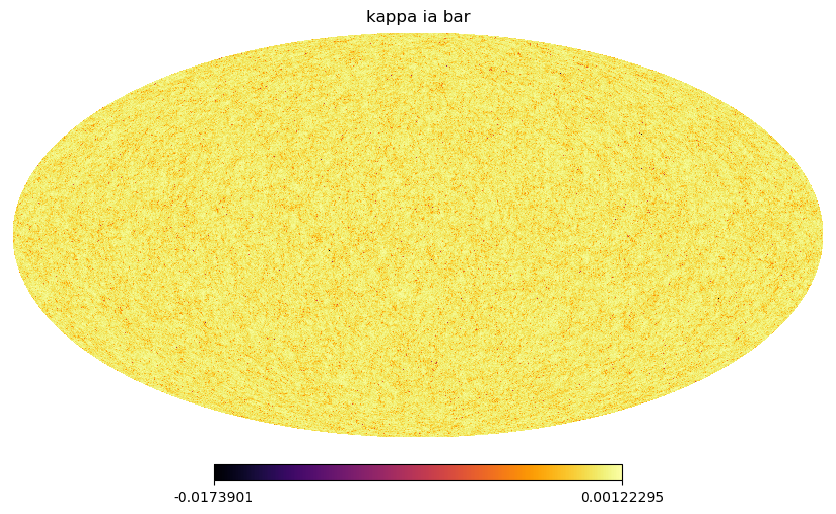

In [23]:
hp.mollview(kappa_ia_bar, title='kappa ia bar', cmap='inferno')
plt.savefig('../Plots/kappa_ia_bar.png', dpi=300)
plt.show()

In [24]:
#Compare the power spectrum with the prediction from cosmoSIS

sim_ia_cls = hp.anafast(kappa_ia_bar, pol=True, lmax=lmax, use_pixel_weights=True)

path = '/home/guerrini/cosmosis-standard-library/ia_pred/shear_cl_ii/'

ell = np.loadtxt(path+'ell.txt')
cl_ii = np.loadtxt(path+'bin_1_1.txt')

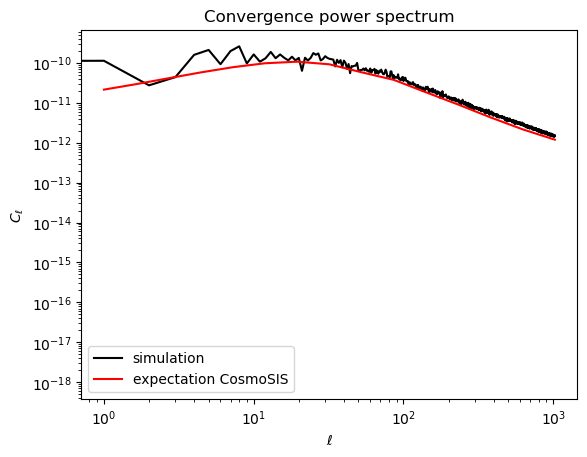

In [25]:
plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_ia_cls, label="simulation", c='k')
plt.plot(ell, cl_ii, label="expectation CosmoSIS", c='r')


plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Convergence power spectrum")

plt.savefig('../Plots/power_spectrum_ia.png', dpi=300)
plt.show()
#Looks good !


In [26]:
kappa_lensing, kappa_ia, gamma_lensing, z_bin_edges, cosmo_params = forward(path_sims, path_info, sim_number=1, nside=512, verbose=True, add_ia=False, A_ia=0.49, eta_ia=0.)

[!] Preprocessing the Gower Street simulation 1...
[!] Reading the cosmological parameters...
[!] Done in 2.99 min.
[!] Extracting overdensity maps and redshift edges for the Gower Street simulation 1...


100it [02:52,  1.73s/it]


[!] Done in 2.89 min.
[!] Number of redshift shells: 77
[!] Larger redshift: 2.07237
[!] Performing the ray tracing using GLASS...


100%|██████████| 77/77 [00:01<00:00, 43.55it/s]


[!] Converting convergence map to shear maps with lmax=1024...


100%|██████████| 77/77 [01:43<00:00,  1.34s/it]


100%|██████████| 77/77 [00:00<00:00, 102.59it/s]


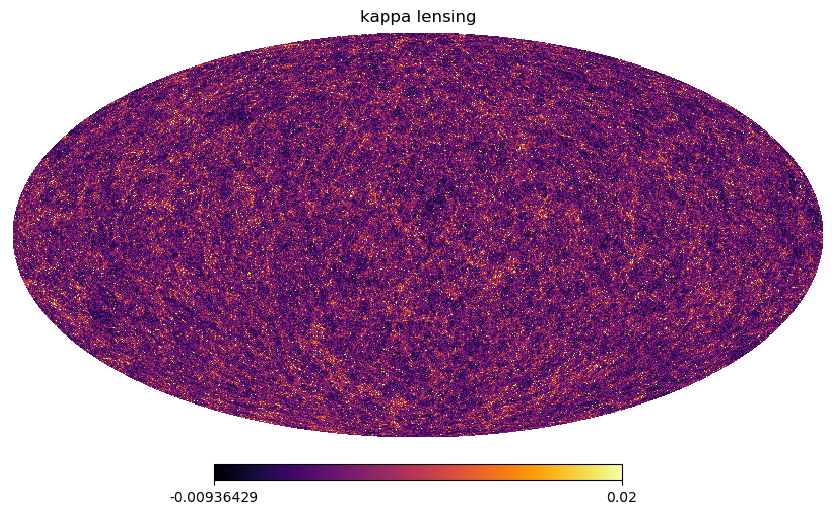

In [27]:
kappa_bar = weight_map_w_redshift(kappa_lensing, z_bin_edges, (dndz, z), verbose=True)

hp.mollview(kappa_bar, title='kappa lensing', cmap='inferno', max=0.02)
plt.show()

100%|██████████| 77/77 [00:00<00:00, 85.29it/s]


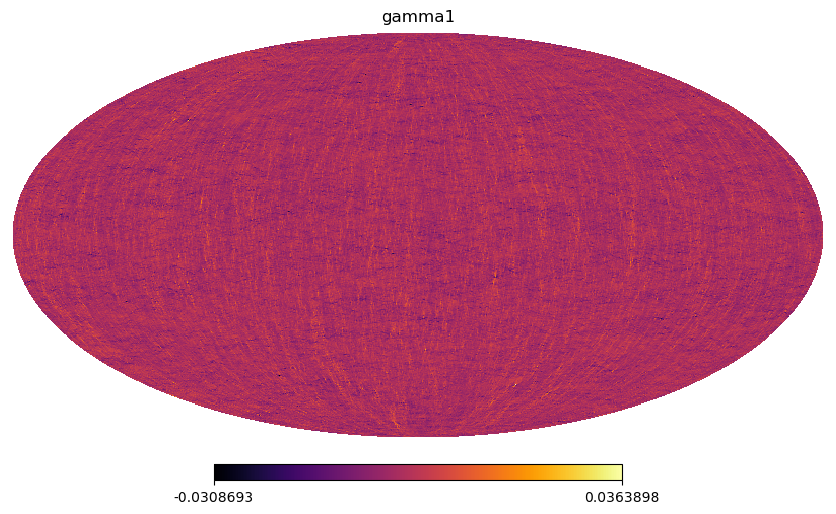

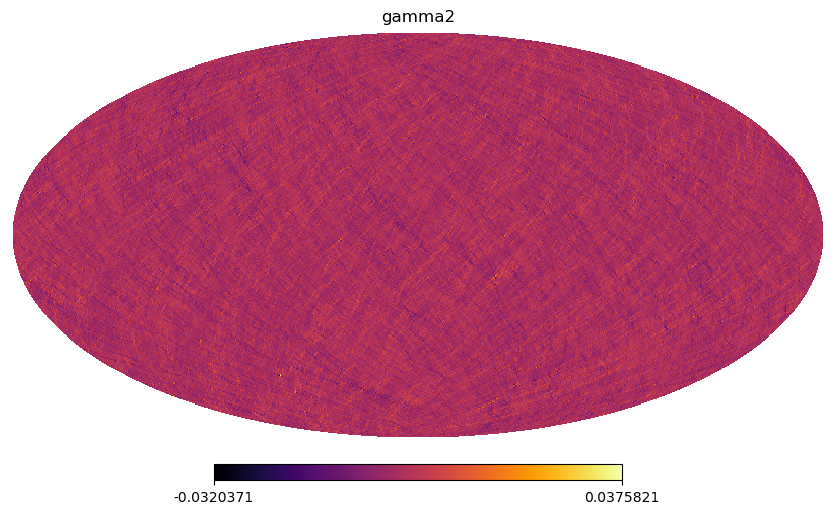

In [28]:
gamma_bar = weight_map_w_redshift(gamma_lensing, z_bin_edges, (dndz, z), verbose=True)

hp.mollview(gamma_bar.real, title='gamma1', cmap='inferno')
plt.show()
hp.mollview(gamma_bar.imag, title='gamma2', cmap='inferno')
plt.show()

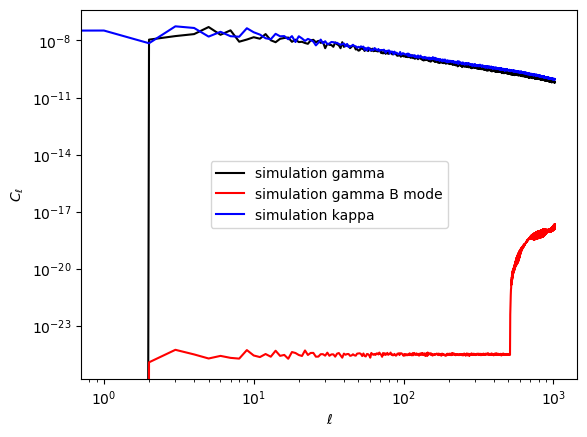

In [37]:
sim_gamma_cls = hp.anafast(np.array([gamma_bar.real, gamma_bar.real, gamma_bar.imag]), pol=True, lmax=lmax, use_pixel_weights=True)


plt.figure()

#get the HEALPix pixel window function since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

l = np.arange(lmax+1)
plt.plot(l, sim_gamma_cls[1], label="simulation gamma", c='k')
plt.plot(l, sim_gamma_cls[2], label="simulation gamma B mode", c='r')
plt.plot(l, sim_cls, label="simulation kappa", c='b')

plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

plt.show()

In [35]:
sim_gamma_cls.shape

(6, 1025)

In [30]:
sim_gamma_cls

array([-1.04708049e-13,  3.89097530e-10, -2.69594308e-09, ...,
       -9.74005222e-13, -8.32660259e-15,  1.80818867e-13])